# **Importing Libraries**

In [5]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.6 MB/s eta 0:00:00


In [6]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from pprint import pprint
import random
from transformers import AutoTokenizer
import os, json


# **Converting JSON File into dataframe**

In [ ]:
def train_json_to_df(train_data_json, separated_columns = ['data','paragraphs','qas','answers'],
                           bool_check = 1):
    if bool_check:
        print("Opening the train json file to read data")    
    file = json.loads(open(train_data_json).read())
    d1 = pd.io.json.json_normalize(file , separated_columns )
    d2 = pd.io.json.json_normalize(file, separated_columns[:-1] )
    r = pd.io.json.json_normalize(file,separated_columns[:-2])
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(d2['id'].values,d2['answers'].str.len())
    d2['context'] = idx
    d1['q_idx'] = ndx
    final_df = pd.concat([ d2[['id','question','context']].set_index('id'),d1.set_index('q_idx')],1,sort=False).reset_index()
    final_df['c_id'] = final_df['context'].factorize()[0]
    if bool_check:
        print("Shape of the final dataframe is {}".format(final_df.shape))
    return final_df

In [ ]:
data = train_json_to_df('train-v2.0.json')
data

Opening the train json file to read data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


Shape of the final dataframe is (130319, 6)


index  \
0       56be85543aeaaa14008c9063   
1       56be85543aeaaa14008c9065   
2       56be85543aeaaa14008c9066   
3       56bf6b0f3aeaaa14008c9601   
4       56bf6b0f3aeaaa14008c9602   
...                          ...   
130314  5a7e070b70df9f001a875439   
130315  5a7e070b70df9f001a87543a   
130316  5a7e070b70df9f001a87543b   
130317  5a7e070b70df9f001a87543c   
130318  5a7e070b70df9f001a87543d   

                                                 question  \
0                When did Beyonce start becoming popular?   
1       What areas did Beyonce compete in when she was...   
2       When did Beyonce leave Destiny's Child and bec...   
3           In what city and state did Beyonce  grow up?    
4              In which decade did Beyonce become famous?   
...                                                   ...   
130314  Physics has broadly agreed on the definition o...   
130315               Who coined the term partonic matter?   
130316              What is another name for anti-matter?   
130317  Matter usually does not need to be used in con...   
130318  What field of study has a variety of unusual c...   

                                                  context  \
0       Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
1       Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
2       Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
3       Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
4       Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
...                                                   ...   
130314  The term "matter" is used throughout physics i...   
130315  The term "matter" is used throughout physics i...   
130316  The term "matter" is used throughout physics i...   
130317  The term "matter" is used throughout physics i...   
130318  The term "matter" is used throughout physics i...   

                       text  answer_start   c_id  
0         in the late 1990s         269.0      0  
1       singing and dancing         207.0      0  
2                      2003         526.0      0  
3            Houston, Texas         166.0      0  
4                late 1990s         276.0      0  
...                     ...           ...    ...  
130314                  NaN           NaN  19028  
130315                  NaN           NaN  19028  
130316                  NaN           NaN  19028  
130317                  NaN           NaN  19028  
130318                  NaN           NaN  19028  

[130319 rows x 6 columns]

In [ ]:
data['c_id'].unique().size

19029

# **Exploratory Data Analysis**

**Removing NA values for EDA**

In [ ]:
df_nonna=data.dropna()

## **Cleaning the data**

In [ ]:
#using HW1's clean_message function to clean the input data
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''
    ps = PorterStemmer()
    message_to_lower = message.lower() 
    message_punct_rem = re.sub(r'[^\w\s]', '', message_to_lower) 
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    message = re.sub(regex, '', message_punct_rem)
    messages_split = message.split(' ') 
    messages_cleaned = [x for x in messages_split if x not in stopwords.words('english')]  
    return ' '.join(messages_cleaned)

data_cleaned = [clean_message(x) for x in df_nonna['question']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Implementing TF-IDF Vectorizer on cleaned data to vectorize**

In [ ]:
### vectorize the dataset using count vectorizer or tfidf vectorizer and store the vectors in a separate variable
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer =  TfidfVectorizer(stop_words={'english'})
vecs = tfidfvectorizer.fit_transform(data_cleaned)

Taking a sample of 8000 records of training data to visualize the most repeated words in a cluster

In [ ]:
vecs_1=vecs[:8000]

In [ ]:
from sklearn.cluster import AgglomerativeClustering
### importing dependencies for agglomerative clustering ###

### perform agglomerative clustering on the vectors

agg_clust_model = AgglomerativeClustering(n_clusters=7)
clustering = agg_clust_model.fit(vecs_1.toarray())
clusters = clustering.labels_


In [ ]:
#mapping each question with cluster number into a dataframe
clusters_df=pd.DataFrame(list(zip(vecs_1,clusters)),columns=['Article_Title','Cluster_number'])
print(clusters_df.sort_values(by=['Cluster_number']))

                                          Article_Title  Cluster_number
0       (0, 27884)\t0.46840745992057503\n  (0, 4800)...               0
5024    (0, 23211)\t0.6124593876968307\n  (0, 17994)...               0
5023    (0, 15325)\t0.5148236410278358\n  (0, 18949)...               0
5022    (0, 39495)\t0.4997491948992285\n  (0, 15325)...               0
5021    (0, 9759)\t0.5190113995753767\n  (0, 17995)\...               0
...                                                 ...             ...
4655    (0, 30240)\t0.4373030408005004\n  (0, 30085)...               6
4653    (0, 11527)\t0.46664406462380054\n  (0, 19750...               6
4652    (0, 9066)\t0.5412082024765209\n  (0, 34143)\...               6
4693    (0, 38461)\t0.35020602694837655\n  (0, 1600)...               6
4686    (0, 28625)\t0.6158777270286675\n  (0, 3204)\...               6

[8000 rows x 2 columns]


Printing the wordclouds to show most common terms out of the questions asked

Cluster 1


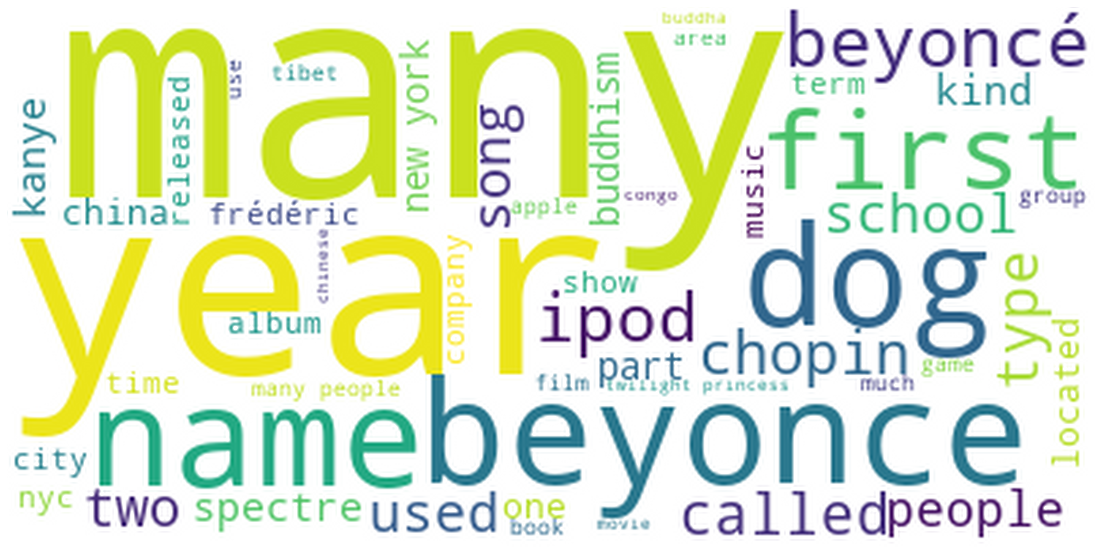

Cluster 2


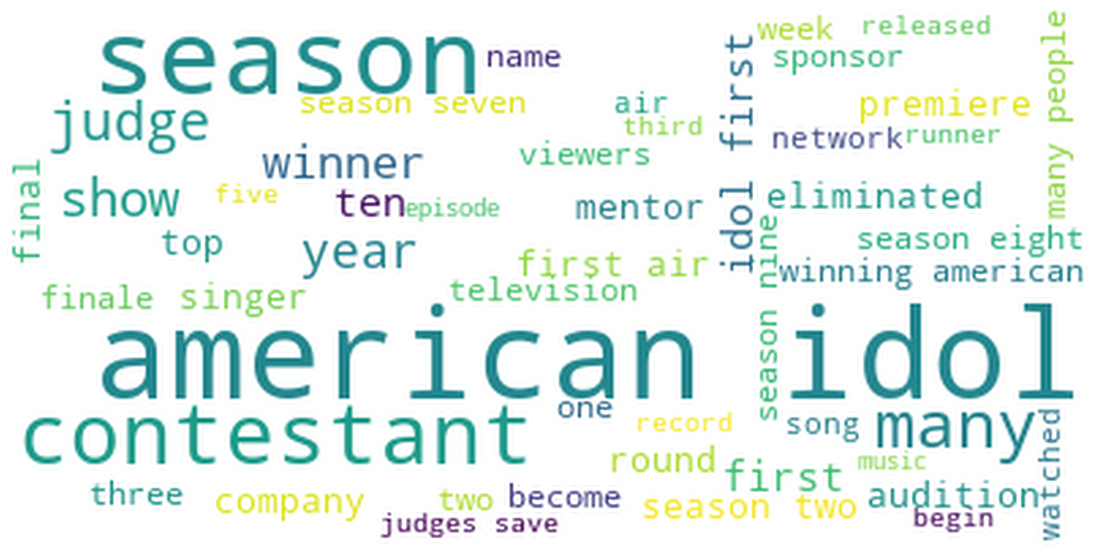

Cluster 3


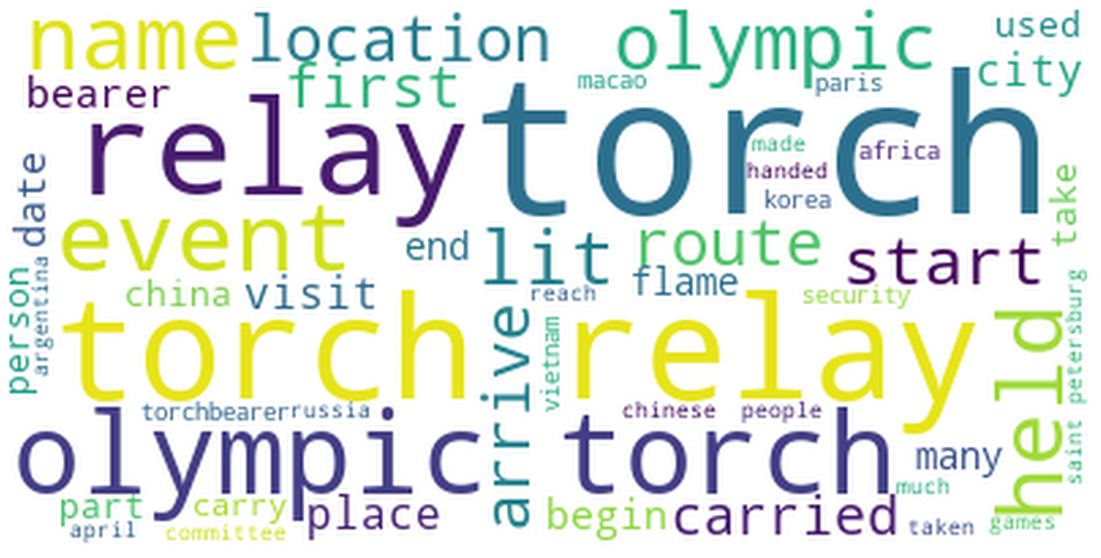

Cluster 4


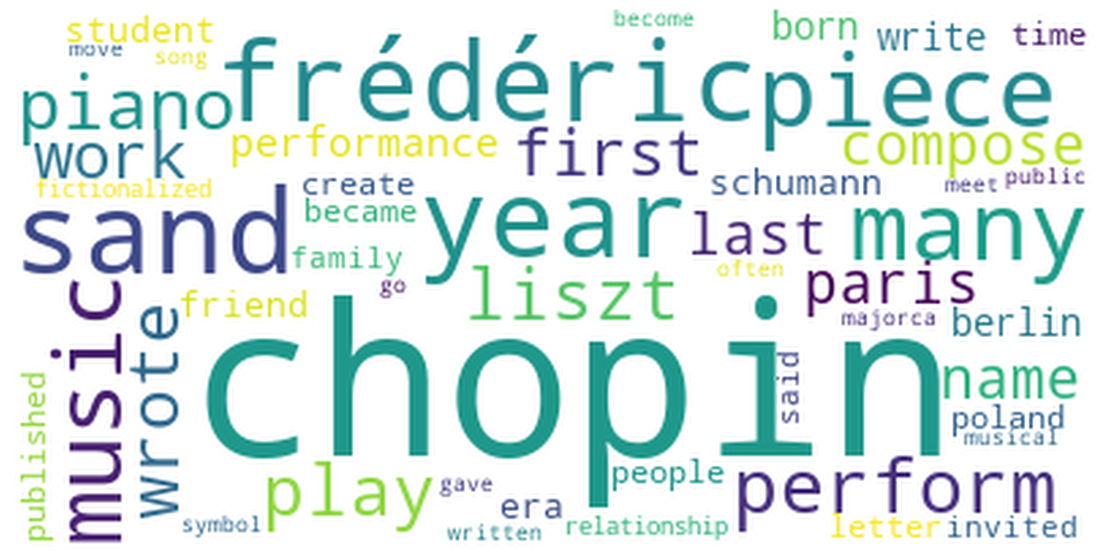

Cluster 5


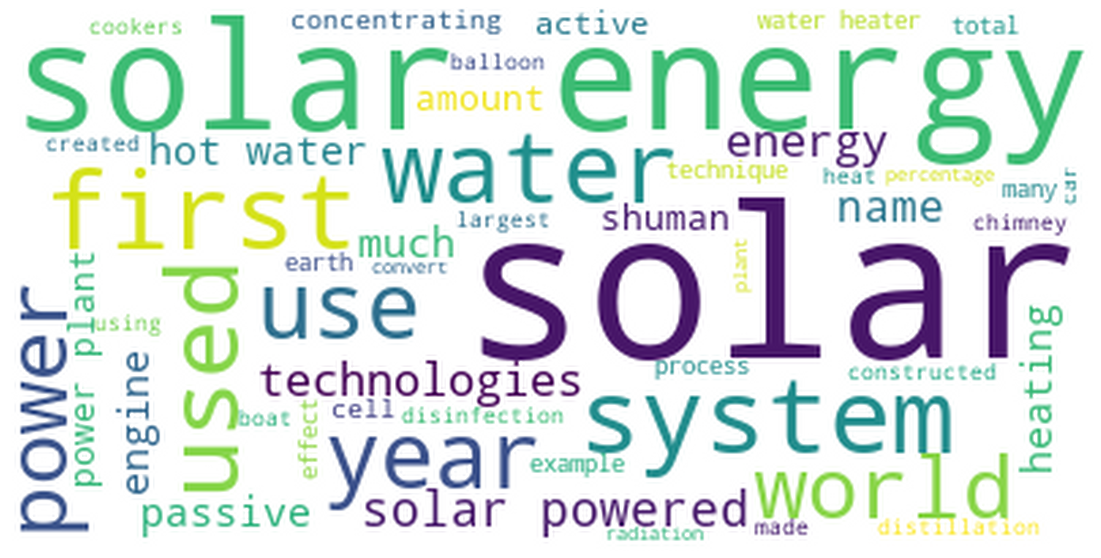

Cluster 6


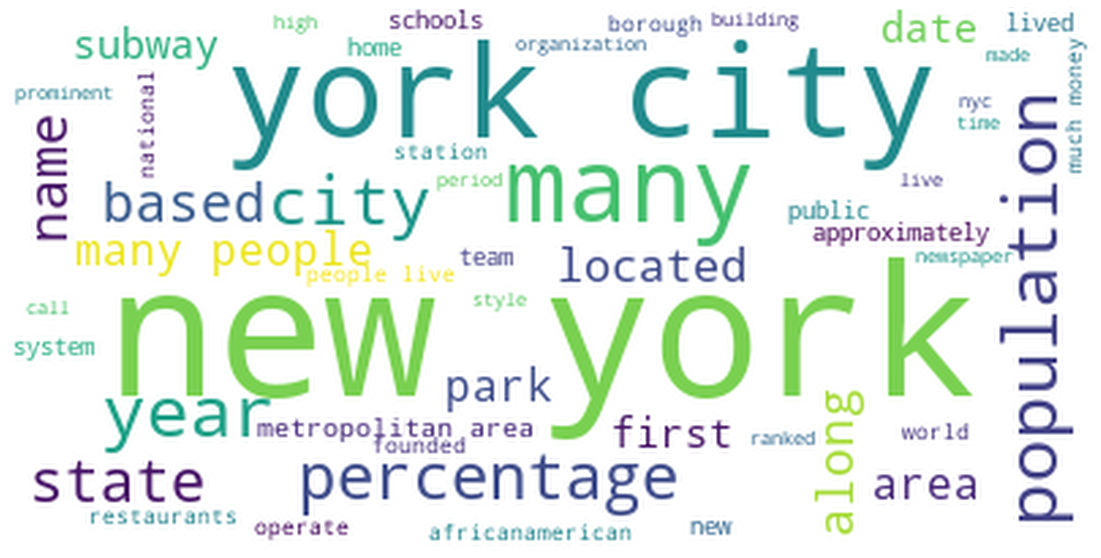

Cluster 7


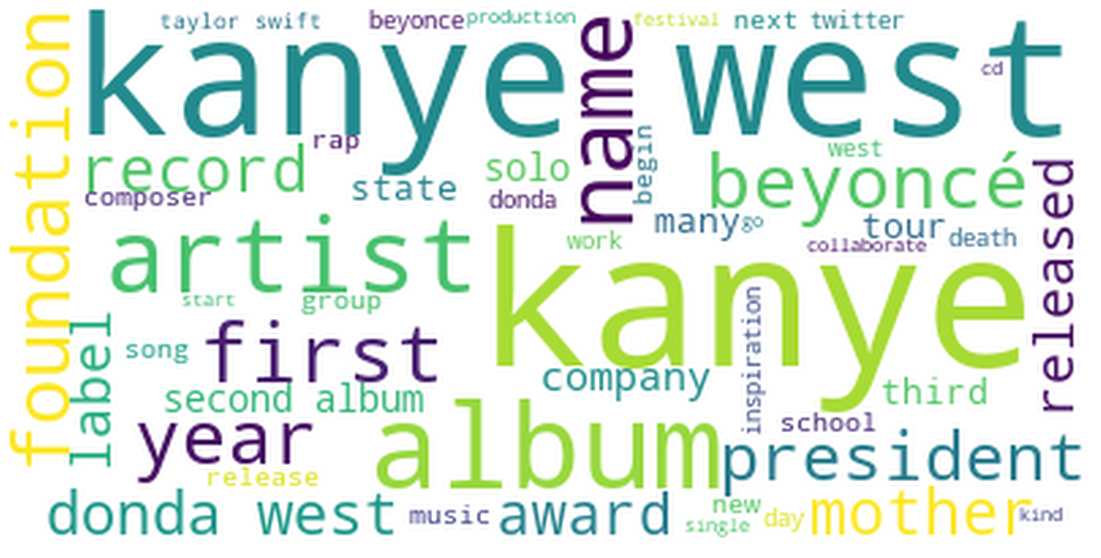

In [ ]:
### importing dependencies for plotting clusters using wordcloud ###
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### plot the clusters using word clouds
wc={'cluster':clusters,'wiki':data[:8000]}
word_cloud_df=pd.DataFrame(wc)


for i in range(0, 7):
    x=word_cloud_df[word_cloud_df.cluster==i]
    tokens=x['wiki'].str.cat(sep=' ')

    word_cloud = WordCloud(max_words=50, background_color="white").generate(tokens)
    plt.figure(figsize=(20, 10))
    plt.imshow(word_cloud, interpolation="lanczos")
    print("Cluster",i+1)
    plt.axis("off")
    plt.show()
### Below output is just for your reference purposes.
###Your output is not going to be the same as the output provided below as the list of articles is going to be different '''

Here

# **Question Answering using RoBERTa Model**

In [7]:
# Function to read input from the specified path

def read_input(file: str) -> tuple:    
    location = os.path.join(os.getcwd(), file)
    with open(location, "rb") as json_input:
        dictionary = json.load(json_input)
    contexts, questions, answers = list(), list(), list()
    
# Extracting the contexts, questions and answers from the SQUAD 2.0 dataset

    for sample in dictionary['data']:
        for passage in sample['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                
# Answers and Plausible answers separation

                access = "plausible_answers" if "plausible_answers" in qa.keys() else 'answers'
                for answer in qa[access]:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    
    return contexts, questions, answers

In [10]:
train_contexts, train_questions, train_answers = read_input('train-v2.0.json')
valid_contexts, valid_questions, valid_answers = read_input('dev-v2.0.json')

In [11]:
# Randomly printing 5 contexts, questions and answers from the dataset

random.seed(89)

ind = random.sample(range(0, len(train_contexts)), 5)
for index in ind:
    print(f'Q:  {train_questions[index]}\n')
    print("Context:\n")
    pprint(train_contexts[index])
    print(f"\nAnswer:[{train_answers[index]}]\n")
    print("-" * 100)

Q:   What style came before Modernism?

Context:

('Architects such as Mies van der Rohe, Philip Johnson and Marcel Breuer '
 'worked to create beauty based on the inherent qualities of building '
 'materials and modern construction techniques, trading traditional historic '
 'forms for simplified geometric forms, celebrating the new means and methods '
 'made possible by the Industrial Revolution, including steel-frame '
 'construction, which gave birth to high-rise superstructures. By mid-century, '
 'Modernism had morphed into the International Style, an aesthetic epitomized '
 "in many ways by the Twin Towers of New York's World Trade Center designed by "
 'Minoru Yamasaki.')

Answer:[{'text': 'International', 'answer_start': 464}]

----------------------------------------------------------------------------------------------------
Q:  What label avoided this scene?

Context:

('The innovative production techniques devised by post-punk producers such as '
 'Martin Hannett and Denni

In [12]:
# Since the dataset only has start_index, this function calculates the End index and appends it to the train_answers and valid_answers variables

def answer_end(answers: list, contexts: list) -> list:
    _answers = answers.copy()
    for answer, context in zip(_answers, contexts):
        answer_bound = answer['text']
        start_idx = answer['answer_start']
        answer['answer_end'] = start_idx + len(answer_bound)
    return _answers

In [13]:
train_answers = answer_end(train_answers, train_contexts)
valid_answers = answer_end(valid_answers, valid_contexts)

In [14]:
# Intializing the autotokenizer library for the model 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=True)

In [15]:
# Encoding the dataset contexts, questions and answers

def encode_data(contexts: list, questions: list, answers: list) -> dict:

# Tokenizing the input and extracting the encodings 

    encodings = tokenizer(contexts, questions, truncation=True, padding=True, return_tensors="pt")
    start_positions, end_positions = list(), list()

    for index in range(len(answers)):
        start_value = encodings.char_to_token(index, answers[index]['answer_start'])
        end_value   = encodings.char_to_token(index, answers[index]['answer_end'])

# if start position is None, answer is truncated

        if start_value is None:
            start_value = tokenizer.model_max_length
        
# If end position cannot be found, shift position until found

        shift = 1
        while end_value is None:
            end_value = encodings.char_to_token(index, answers[index]['answer_end'] - shift)
            shift += 1

        start_positions.append(start_value)
        end_positions.append(end_value)

    encodings.update({
        'start_positions': start_positions, 'end_positions': end_positions
    })
    return encodings

In [16]:
# Training the entire datset was taking more than 6 days to train. So we have reduced the input dataset size to 10000 contexts and evaluation size to 500 questions for simplicity

train_encodings = encode_data(train_contexts[0:5000], train_questions[0:5000], train_answers[0:5000])
valid_encodings = encode_data(valid_contexts[0:500], valid_questions[0:500], valid_answers[0:500])

In [17]:
# Deleting the old variables containing non-encoded data

del train_contexts, train_questions, train_answers
del valid_contexts, valid_questions, valid_answers

In [18]:
# Importing the pytorch for model bulding and intitializing dataset

import torch
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: dict) -> None:
        self.encodings = encodings

    def __getitem__(self, index: int) -> dict:
        return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    
    def __len__(self):
        return len(self.encodings['input_ids'])

In [19]:
train_ds = SquadDataset(train_encodings)
valid_ds = SquadDataset(valid_encodings)

In [20]:
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained('roberta-base')
# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
model.to(device)
# activate training mode of model
model.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [21]:
"""
This cell is adopted from `https://github.com/michaelrzhang/lookahead/blob/master/lookahead_pytorch.py`, which is the
source code of `Lookahead Optimizer: k steps forward, 1 step back` paper (https://arxiv.org/abs/1907.08610).
"""

from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer


class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(param_state['cached_params'], alpha=1.0 - self.la_alpha)  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

**Model training**

In [22]:
# Initialize adam optimizer with weight decay to minimize overfit

from transformers import AdamW

base  = AdamW(model.parameters(), lr=1e-4)
optim = Lookahead(base)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from torch.utils.data import DataLoader
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")


# Initialize data loader for training data

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)


for epoch in range(5):
    model.train()
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

Epoch 4: 100%|██████████| 313/313 [07:40<00:00,  1.47s/it, loss=0.329]


In [24]:
# Saving the model in a local directory

MODEL_DIR = "./model"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
model.save_pretrained(MODEL_DIR)
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
MODEL_DIR = "./model"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_DIR)

**Model Evaluation**

In [26]:
from torch.utils.data import DataLoader

# Switching model to evaluation mode

model.eval()
model = model.to(device)
val_loader = DataLoader(valid_ds, batch_size=16)
acc = list()
for batch in val_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        
# Calculating average accuracy in total

print(f"Score of the model based on EM: {sum(acc)/len(acc)}")

Score of the model based on EM: 0.650390625


In [30]:
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

# Switching model to evaluation mode

model.eval()
model = model.to(device)
val_loader = DataLoader(valid_ds, batch_size=16)
start_true_all, end_true_all = [], []
start_pred_all, end_pred_all = [], []
for batch in val_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)
        start_true_all.extend(start_true.tolist())
        end_true_all.extend(end_true.tolist())
        start_pred_all.extend(start_pred.tolist())
        end_pred_all.extend(end_pred.tolist())

# Calculating F1 score for start and end positions

start_f1 = f1_score(start_true_all, start_pred_all, average='macro')
end_f1 = f1_score(end_true_all, end_pred_all, average='macro')
overall_f1 = (start_f1 + end_f1) / 2

print(f"F1 score of the model: {overall_f1:.3f}")

F1 score of the model: 0.530


In [27]:
# Returns answer to a given a question
def answer_to_questions(context: str, questions: list) -> list:
    encodings = tokenizer([context]*len(questions), questions, truncation=True, padding=True, return_tensors="pt")
    encodings = encodings.to(device)
    outputs = model(**encodings)
    start_pred = torch.argmax(outputs['start_logits'], dim=1)
    end_pred = torch.argmax(outputs['end_logits'], dim=1)  
    answers = list()
    for index, (start_idx, end_idx) in enumerate(zip(start_pred, end_pred)):
        tokens = tokenizer.convert_ids_to_tokens(encodings['input_ids'][index][start_idx:end_idx+1])
        answers.append(tokenizer.convert_tokens_to_string(tokens) )
    print("Context:")
    pprint(context)
    print()
    for question, answer in zip(questions, answers):
        print(f"Q:  {question}")
        print(f"A:  {answer}")
        print("-"*60)
    return answers

**Sample answers from the model**

In [28]:
context = "The modern Olympic Games or Olympics (French: Jeux olympiques)[1][2] are leading international sporting events featuring summer and winter sports competitions in which thousands of athletes from around the world participate in a variety of competitions. The Olympic Games are considered the world's foremost sports competition with more than 200 nations participating.[3] The Olympic Games are normally held every four years, alternating between the Summer and Winter Olympics every two years in the four-year period."
questions = [
    "How often do the Olympic games hold?",
    "How many nations do participate in each Olympic?"
]

_ = answer_to_questions(context, questions)

Context:
('The modern Olympic Games or Olympics (French: Jeux olympiques)[1][2] are '
 'leading international sporting events featuring summer and winter sports '
 'competitions in which thousands of athletes from around the world '
 'participate in a variety of competitions. The Olympic Games are considered '
 "the world's foremost sports competition with more than 200 nations "
 'participating.[3] The Olympic Games are normally held every four years, '
 'alternating between the Summer and Winter Olympics every two years in the '
 'four-year period.')

Q:  How often do the Olympic games hold?
A:   every four years,
------------------------------------------------------------
Q:  How many nations do participate in each Olympic?
A:   more than 200
------------------------------------------------------------


In [29]:
context = "Vikings is the modern name given to seafaring people primarily from Scandinavia (present-day Denmark, Norway and Sweden), who from the late 8th to the late 11th centuries raided, pirated, traded and settled throughout parts of Europe. They also voyaged as far as the Mediterranean, North Africa, the Middle East, and North America. In some of the countries they raided and settled in, this period is popularly known as the Viking Age, and the term \"Viking\" also commonly includes the inhabitants of the Scandinavian homelands as a collective whole. The Vikings had a profound impact on the Early medieval history of Scandinavia, the British Isles, France, Estonia, and Kievan Rus'."
questions = [
    "When vikings started raided?",
]

_ = answer_to_questions(context, questions)

Context:
('Vikings is the modern name given to seafaring people primarily from '
 'Scandinavia (present-day Denmark, Norway and Sweden), who from the late 8th '
 'to the late 11th centuries raided, pirated, traded and settled throughout '
 'parts of Europe. They also voyaged as far as the Mediterranean, North '
 'Africa, the Middle East, and North America. In some of the countries they '
 'raided and settled in, this period is popularly known as the Viking Age, and '
 'the term "Viking" also commonly includes the inhabitants of the Scandinavian '
 'homelands as a collective whole. The Vikings had a profound impact on the '
 'Early medieval history of Scandinavia, the British Isles, France, Estonia, '
 "and Kievan Rus'.")

Q:  When vikings started raided?
A:   late 8th to the late 11th centuries
------------------------------------------------------------
